# Modelling

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
X_train=np.load('Pneumonia_X_train.npy')
y_train=np.load('Pneumonia_y_train.npy')

X_dev=np.load('Pneumonia_X_dev.npy')
y_dev=np.load('Pneumonia_y_dev.npy')


In [3]:
for data in [X_train, y_train, X_dev , y_dev]:
    print(np.shape(data))

(1800, 256, 256, 3)
(1800, 1)
(600, 256, 256, 3)
(600, 1)


## Create base models 

In [4]:
base_models={'VGG16':tf.keras.applications.VGG16, 'InceptionV3':tf.keras.applications.InceptionV3, 'ResNet50':tf.keras.applications.ResNet50}

In [5]:
# This could be done explicitely for each model but this seemed neater, 
def create_base_model(model_key):
    pre_trained_model=base_models[model_key]
    base_model=pre_trained_model(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=(256, 256, 3),
        pooling=None,)
    
    base_model.trainable=False
    
    return base_model 

## Simplest style of models 

The first idea to test is simply using the pretrained models with global average pooling and a sigmoid layer added.

In [6]:
def model_type_1(model_key, learning_rate=0.001):
    base_model=create_base_model(model_key)
    built_model=tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1,activation='sigmoid')])

    built_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    
    return built_model 

## Training

In [7]:
'''for model_key in base_models.keys():
    print(model_key)
    current_model=model_type_1(model_key)
    current_model.fit(X_train, y_train,epochs=10, validation_data=(X_dev,y_dev),batch_size=16)
    current_model.save(f'Saved_models/{model_key}_type_1_batch16',save_format='h5')
    np.save(f'Saved_history/{model_key}_type_1_batch16_history',current_model.history.history)
    tf.keras.backend.clear_session()''' 
    

"for model_key in base_models.keys():\n    print(model_key)\n    current_model=model_type_1(model_key)\n    current_model.fit(X_train, y_train,epochs=10, validation_data=(X_dev,y_dev),batch_size=16)\n    current_model.save(f'Saved_models/{model_key}_type_1_batch16',save_format='h5')\n    np.save(f'Saved_history/{model_key}_type_1_batch16_history',current_model.history.history)\n    tf.keras.backend.clear_session()"

In [8]:
list(base_models.keys())

['VGG16', 'InceptionV3', 'ResNet50']

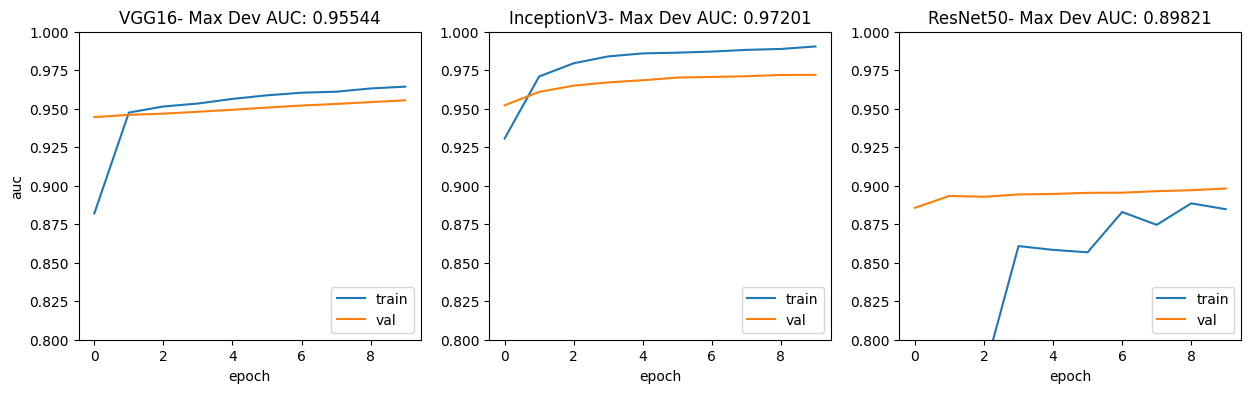

In [9]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
axs[0].set_ylabel('auc')
for i in range(3):
    model_key=list(base_models.keys())[i]
    model_history=np.load(f'Saved_history/{model_key}_type_1_batch16_history.npy',allow_pickle=True).item()
    max_auc=round(np.max(model_history['val_auc']),5)
    axs[i].set_title(f'{model_key}- Max Dev AUC: {max_auc}')
    axs[i].plot(model_history['auc'])
    axs[i].plot(model_history['val_auc'])
    axs[i].set_xlabel('epoch')
    axs[i].set_ylim([0.8, 1])
    axs[i].legend(['train', 'val'], loc='lower right')
plt.show()

## Developing Inception model further

In [10]:
InceptionV3_history=np.load('Saved_history/InceptionV3_type_1_batch16_history.npy',allow_pickle=True).item()
Train_AUC=InceptionV3_history['auc'][-1]
Dev_AUC=InceptionV3_history['val_auc'][-1]
print('Train AUC',Train_AUC)
print('Dev AUC',Dev_AUC)
print('difference (varience estimate)',Train_AUC-Dev_AUC)
print('1- Train_Auc (bias estimate)',1-Train_AUC)

Train AUC 0.9904401302337646
Dev AUC 0.9720110297203064
difference (varience estimate) 0.018429100513458252
1- Train_Auc (bias estimate) 0.009559869766235352


After the first round of training, the best performing model is the inception model, with a batch size of 16 so this is the model we'll develop further. 

To iterate on this model, we need to consider if bias or viariance is the larger issue we need to adress. To consider variance we can compare AUC score for the Train and Dev sets, bias is a little harder. To properly consider bias we would need an estimate of the bayes optimal error, which would often use human level performance to assess, unfortunately we don't have this information here. As an pessimistic estimate we'll consider 1-the Train set AUC as the bias (pessimistic because this assumes bayes optimal error is zero)

At this stage our bias estimate is smaller our variance estimate so let us first investigate addressing overfitting.

## Regularisation

In [11]:
def InceptionV3_type_1_regularised(kernel_regularizer=None,activity_regularizer=None,learning_rate=0.001):
    base_model=create_base_model('InceptionV3')
    built_model=tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1,kernel_regularizer=kernel_regularizer),
        tf.keras.layers.Activation('sigmoid')])

    built_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    
    return built_model 

In [12]:
'''for L1_value in [0.001,0.01,0.1]:
    current_model=InceptionV3_type_1_regularised(kernel_regularizer=tf.keras.regularizers.L1(L1_value))
    current_model.fit(X_train, y_train,epochs=10, validation_data=(X_dev,y_dev),batch_size=16)
    current_model.save(f'Saved_models/InceptionV3_type_1_L1_{L1_value}',save_format='h5')
    np.save(f'Saved_history/InceptionV3_type_1_L1_{L1_value}_history',current_model.history.history)
    tf.keras.backend.clear_session()'''

"for L1_value in [0.001,0.01,0.1]:\n    current_model=InceptionV3_type_1_regularised(kernel_regularizer=tf.keras.regularizers.L1(L1_value))\n    current_model.fit(X_train, y_train,epochs=10, validation_data=(X_dev,y_dev),batch_size=16)\n    current_model.save(f'Saved_models/InceptionV3_type_1_L1_{L1_value}',save_format='h5')\n    np.save(f'Saved_history/InceptionV3_type_1_L1_{L1_value}_history',current_model.history.history)\n    tf.keras.backend.clear_session()"

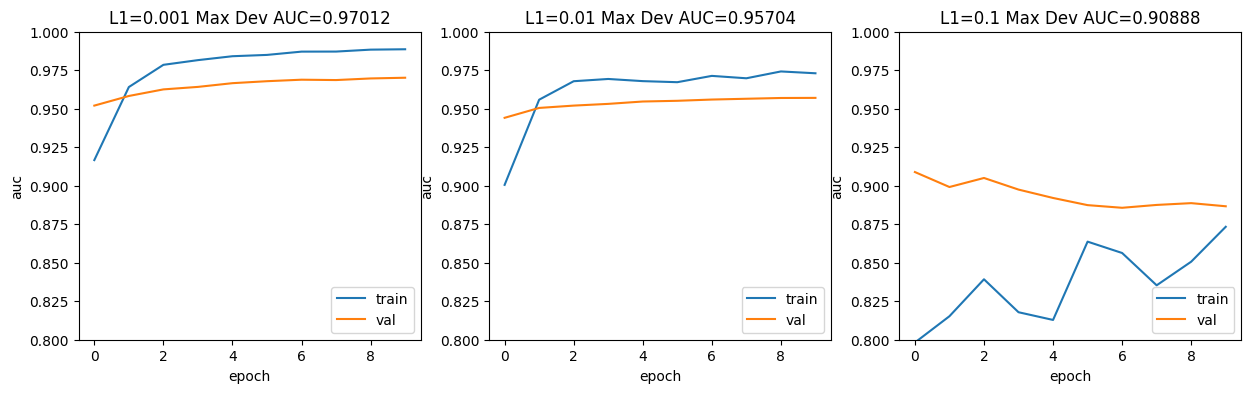

In [13]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
axs[0].set_ylabel('auc')
L1_values=[0.001,0.01,0.1]
for i in range(3):
    L1_value=L1_values[i]
    model_history=np.load(f'Saved_history/InceptionV3_type_1_L1_{L1_value}_history.npy',allow_pickle=True).item()
    max_auc=round(np.max(model_history['val_auc']),5)
    axs[i].set_title(f'L1={L1_value} Max Dev AUC={max_auc}')
    axs[i].plot(model_history['auc'])
    axs[i].plot(model_history['val_auc'])
    axs[i].set_ylabel('auc')
    axs[i].set_xlabel('epoch')
    axs[i].set_ylim([0.8, 1])
    axs[i].legend(['train', 'val'], loc='lower right')
plt.show()

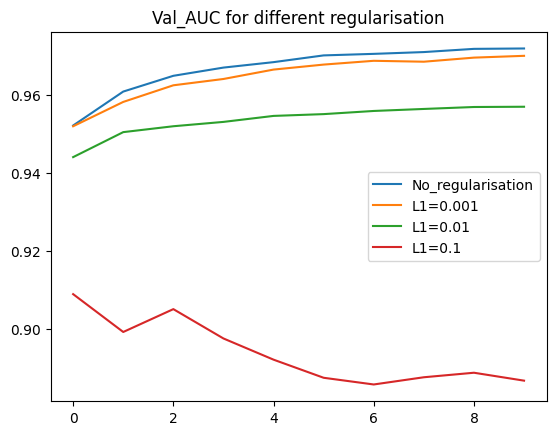

In [14]:
plt.figure()
plt.title('Val_AUC for different regularisation')

model_history=np.load(f'Saved_history/InceptionV3_type_1_batch16_history.npy',allow_pickle=True).item()
plt.plot(model_history['val_auc'])

for L1_value in [0.001,0.01,0.1]:
    model_history=np.load(f'Saved_history/InceptionV3_type_1_L1_{L1_value}_history.npy',allow_pickle=True).item()
    plt.plot(model_history['val_auc'])
    
plt.legend(['No_regularisation','L1=0.001','L1=0.01','L1=0.1'])
plt.show()

## L2 

In [15]:
'''for L2_value in [0.001,0.01,0.1]:
    current_model=InceptionV3_type_1_regularised(kernel_regularizer=tf.keras.regularizers.L2(L2_value))
    current_model.fit(X_train, y_train,epochs=10, validation_data=(X_dev,y_dev),batch_size=16)
    current_model.save(f'Saved_models/InceptionV3_type_1_L2_{L2_value}',save_format='h5')
    np.save(f'Saved_history/InceptionV3_type_1_L2_{L2_value}_history',current_model.history.history)
    tf.keras.backend.clear_session()'''

"for L2_value in [0.001,0.01,0.1]:\n    current_model=InceptionV3_type_1_regularised(kernel_regularizer=tf.keras.regularizers.L2(L2_value))\n    current_model.fit(X_train, y_train,epochs=10, validation_data=(X_dev,y_dev),batch_size=16)\n    current_model.save(f'Saved_models/InceptionV3_type_1_L2_{L2_value}',save_format='h5')\n    np.save(f'Saved_history/InceptionV3_type_1_L2_{L2_value}_history',current_model.history.history)\n    tf.keras.backend.clear_session()"

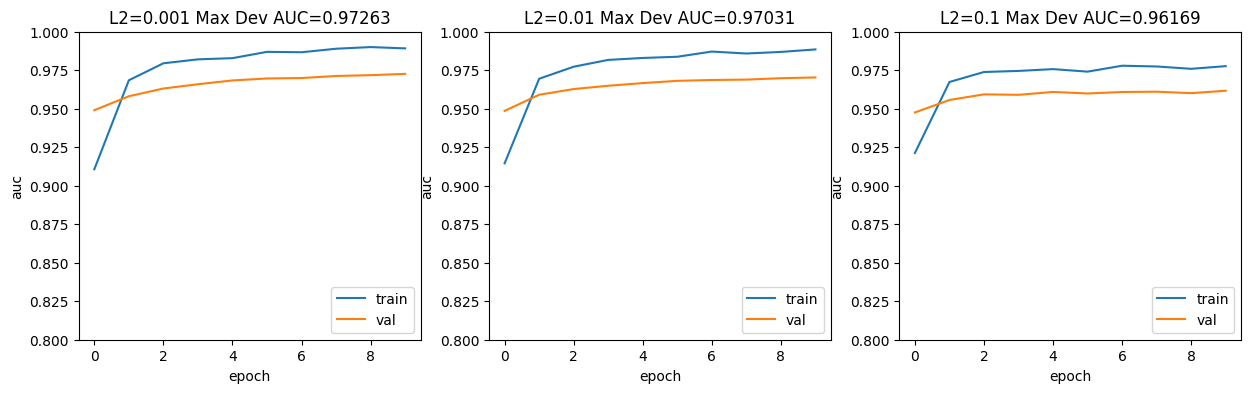

In [16]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
axs[0].set_ylabel('auc')
L2_values=[0.001,0.01,0.1]
for i in range(3):
    L2_value=L2_values[i]
    model_history=np.load(f'Saved_history/InceptionV3_type_1_L2_{L2_value}_history.npy',allow_pickle=True).item()
    max_auc=round(np.max(model_history['val_auc']),5)
    axs[i].set_title(f'L2={L2_value} Max Dev AUC={max_auc}')
    axs[i].plot(model_history['auc'])
    axs[i].plot(model_history['val_auc'])
    axs[i].set_ylabel('auc')
    axs[i].set_xlabel('epoch')
    axs[i].set_ylim([0.8, 1])
    axs[i].legend(['train', 'val'], loc='lower right')
plt.show()

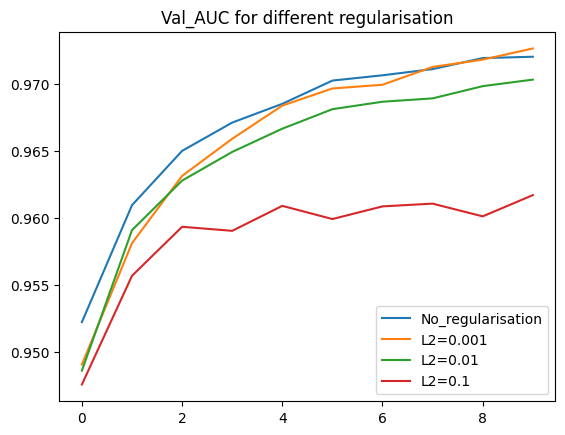

In [17]:
plt.figure()
plt.title('Val_AUC for different regularisation')

model_history=np.load(f'Saved_history/InceptionV3_type_1_batch16_history.npy',allow_pickle=True).item()
plt.plot(model_history['val_auc'])

for L2_value in [0.001,0.01,0.1]:
    model_history=np.load(f'Saved_history/InceptionV3_type_1_L2_{L2_value}_history.npy',allow_pickle=True).item()
    plt.plot(model_history['val_auc'])
    
plt.legend(['No_regularisation','L2=0.001','L2=0.01','L2=0.1'])
plt.show()

## Dropout

In [18]:
def InceptionV3_type_1_dropout(dropout_rate=0, learning_rate=0.001):
    base_model=create_base_model('InceptionV3')
    built_model=tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(1,activation='sigmoid')])

    built_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    
    return built_model 

In [19]:
'''for dropout in [0.1,0.2,0.5]:
    current_model=InceptionV3_type_1_dropout(dropout_rate=dropout)
    current_model.fit(X_train, y_train,epochs=10, validation_data=(X_dev,y_dev),batch_size=16)
    current_model.save(f'Saved_models/InceptionV3_type_1_dropout_{dropout}',save_format='h5')
    np.save(f'Saved_history/InceptionV3_type_1_droupout_{dropout}_history',current_model.history.history)
    tf.keras.backend.clear_session()'''

"for dropout in [0.1,0.2,0.5]:\n    current_model=InceptionV3_type_1_dropout(dropout_rate=dropout)\n    current_model.fit(X_train, y_train,epochs=10, validation_data=(X_dev,y_dev),batch_size=16)\n    current_model.save(f'Saved_models/InceptionV3_type_1_dropout_{dropout}',save_format='h5')\n    np.save(f'Saved_history/InceptionV3_type_1_droupout_{dropout}_history',current_model.history.history)\n    tf.keras.backend.clear_session()"

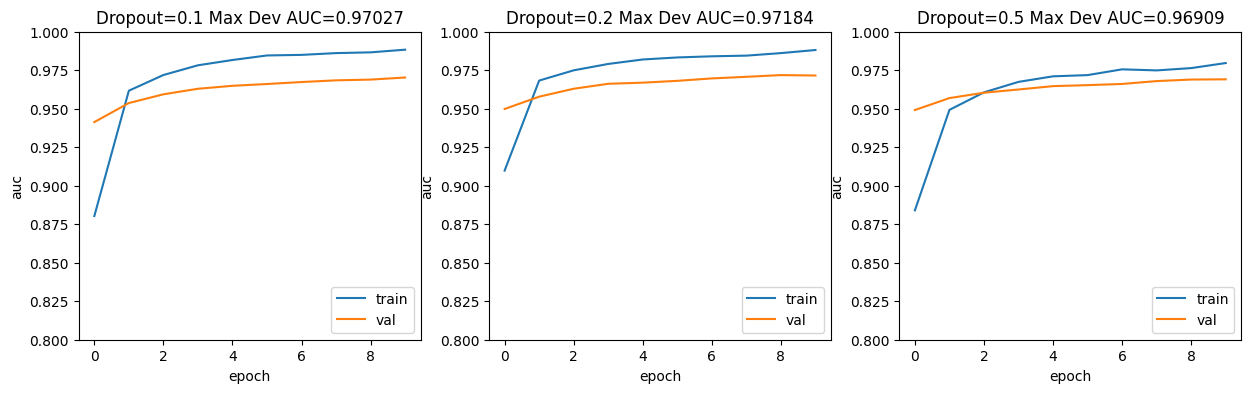

In [20]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
axs[0].set_ylabel('auc')
dropout_values=[0.1,0.2,0.5]
for i in range(3):
    dropout=dropout_values[i]
    model_history=np.load(f'Saved_history/InceptionV3_type_1_droupout_{dropout}_history.npy',allow_pickle=True).item()
    max_auc=round(np.max(model_history['val_auc']),5)
    axs[i].set_title(f'Dropout={dropout} Max Dev AUC={max_auc}')
    axs[i].plot(model_history['auc'])
    axs[i].plot(model_history['val_auc'])
    axs[i].set_ylabel('auc')
    axs[i].set_xlabel('epoch')
    axs[i].set_ylim([0.8, 1])
    axs[i].legend(['train', 'val'], loc='lower right')
plt.show()

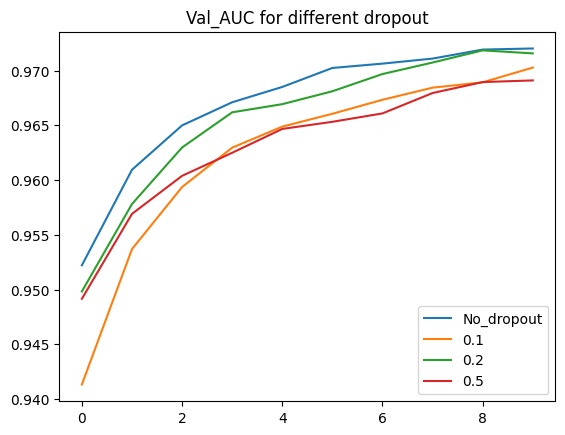

In [21]:
plt.figure()
plt.title('Val_AUC for different dropout')

model_history=np.load(f'Saved_history/InceptionV3_type_1_batch16_history.npy',allow_pickle=True).item()
plt.plot(model_history['val_auc'])

for dropout in [0.1,0.2,0.5]:
    model_history=np.load(f'Saved_history/InceptionV3_type_1_droupout_{dropout}_history.npy',allow_pickle=True).item()
    plt.plot(model_history['val_auc'])
    
plt.legend(['No_dropout','0.1','0.2','0.5'])
plt.show()

## Comparing the methods

In [22]:
No_Reg_history=np.load('Saved_history/InceptionV3_type_1_batch16_history.npy',allow_pickle=True).item()
L1_Reg_historys=[np.load(f'Saved_history/InceptionV3_type_1_L1_{L1_value}_history.npy',allow_pickle=True).item() for L1_value in  [0.001,0.01,0.1]]
L2_Reg_historys=[np.load(f'Saved_history/InceptionV3_type_1_L2_{L2_value}_history.npy',allow_pickle=True).item() for L2_value in  [0.001,0.01,0.1]]
Dropout_Reg_historys=[np.load(f'Saved_history/InceptionV3_type_1_droupout_{dropout}_history.npy',allow_pickle=True).item() for dropout in  [0.1,0.2,0.5]]

In [23]:
L1_Reg_historys[0]['auc'][-1]-L1_Reg_historys[0]['val_auc'][-1]

0.018487870693206787

In [24]:
Overfit_dict={}
Overfit_dict['No_Reg']=No_Reg_history['auc'][-1]-No_Reg_history['val_auc'][-1]

for i in  range(3):
    L1_values=[0.001,0.01,0.1]
    Overfit_dict[f'L1_{L1_values[i]}']=L1_Reg_historys[i]['auc'][-1]-L1_Reg_historys[i]['val_auc'][-1]

for i in  range(3):
    L2_values=[0.001,0.01,0.1]
    Overfit_dict[f'L2_{L2_values[i]}']=L2_Reg_historys[i]['auc'][-1]-L2_Reg_historys[i]['val_auc'][-1]

for i in  range(3):
    Dropout_values=[0.1,0.2,0.5]
    Overfit_dict[f'Dropout_{Dropout_values[i]}']=Dropout_Reg_historys[i]['auc'][-1]-Dropout_Reg_historys[i]['val_auc'][-1]

In [25]:
print(Overfit_dict)
#Overfit_dict.pop('L1_0.1')
#print(Overfit_dict)


{'No_Reg': 0.018429100513458252, 'L1_0.001': 0.018487870693206787, 'L1_0.01': 0.015977919101715088, 'L1_0.1': -0.013323366641998291, 'L2_0.001': 0.016558706760406494, 'L2_0.01': 0.01820141077041626, 'L2_0.1': 0.015953242778778076, 'Dropout_0.1': 0.018069863319396973, 'Dropout_0.2': 0.01656317710876465, 'Dropout_0.5': 0.010565578937530518}


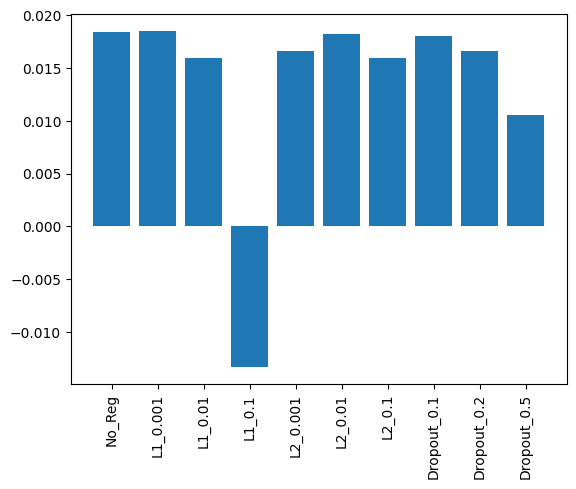

In [26]:
plt.figure()
plt.bar(list(Overfit_dict.keys()),list(Overfit_dict.values()))
plt.xticks(rotation=90)
plt.show()

When we compare train and dev set performance for each of the regularisation options we tried, we can see that we have not been able to noticably improve the model. Using L2 regularisation we achieved a small improvement to dev set performance, though not large enough to be significant. Some of the options tested did have a meaningful positive effect on variance, but unfortunately they also increased bias.

Although there would perhaps be some improvements to be gained by devoting more time to tuning, this generally indicates that the trade of between bias and variance is reasonably good for the unregularied model. To address variance now, we should consider using more data.

## A More complex model

I'm interested to see how a more complex model might perform, considering that so far variance has been a larger issue than bias, I suspect we will only see a drop in performance compared to the earlier models. Let's test this out by adding a dense layer with 10 hidden units between pooling and the final sigmoid layer:

In [36]:
def model_type_2(hidden_units=10, model_key='InceptionV3' ,learning_rate=0.001):
    base_model=create_base_model('InceptionV3')
    built_model=tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(hidden_units),
        tf.keras.layers.Dense(1,activation='sigmoid')])

    built_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])
    
    return built_model

In [37]:
'''current_model=model_type_2()
current_model.fit(X_train, y_train,epochs=10, validation_data=(X_dev,y_dev),batch_size=16)
current_model.save('Saved_models/InceptionV3_type_2',save_format='h5')
np.save('Saved_history/InceptionV3_type_2_history',current_model.history.history)
tf.keras.backend.clear_session()'''

Epoch 1/10
113/113 [==============================] - 17s 105ms/step - loss: 0.3633 - auc: 0.9175 - val_loss: 0.2828 - val_auc: 0.9622
Epoch 2/10
113/113 [==============================] - 8s 73ms/step - loss: 0.2174 - auc: 0.9708 - val_loss: 0.2796 - val_auc: 0.9675
Epoch 3/10
113/113 [==============================] - 8s 73ms/step - loss: 0.1763 - auc: 0.9813 - val_loss: 0.2213 - val_auc: 0.9703
Epoch 4/10
113/113 [==============================] - 8s 74ms/step - loss: 0.1529 - auc: 0.9854 - val_loss: 0.2253 - val_auc: 0.9718
Epoch 5/10
113/113 [==============================] - 8s 73ms/step - loss: 0.1409 - auc: 0.9875 - val_loss: 0.2173 - val_auc: 0.9728
Epoch 6/10
113/113 [==============================] - 8s 73ms/step - loss: 0.1419 - auc: 0.9877 - val_loss: 0.2209 - val_auc: 0.9722
Epoch 7/10
113/113 [==============================] - 8s 73ms/step - loss: 0.1061 - auc: 0.9925 - val_loss: 0.3346 - val_auc: 0.9727
Epoch 8/10
113/113 [==============================] - 8s 74ms/step 

In [39]:
history=np.load('Saved_history/InceptionV3_type_2_history.npy',allow_pickle=True).item()

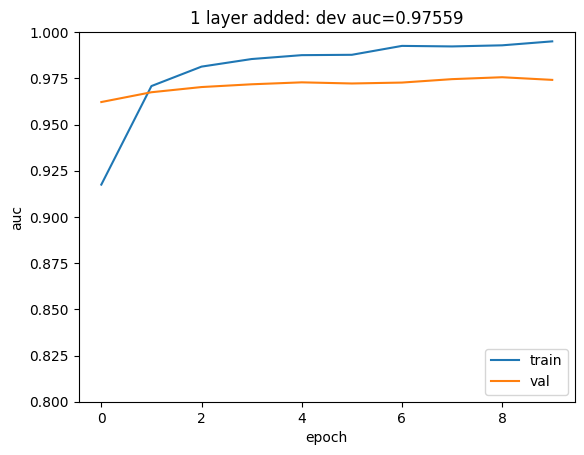

In [48]:
plt.figure()
max_auc=round(np.max(history['val_auc']),5)
plt.title(f'1 layer added: dev auc={max_auc}')
plt.plot(history['auc'])
plt.plot(history['val_auc'])
plt.ylabel('auc')
plt.xlabel('epoch')
plt.ylim([0.8, 1])
plt.legend(['train', 'val'], loc='lower right')
plt.show()

Interestingly, despite expectations, this model offered us a slight improvement in dev set performance. 

In [45]:
Train_AUC=history['auc'][-1]
Dev_AUC=history['val_auc'][-1]
print('Train AUC',Train_AUC)
print('Dev AUC',Dev_AUC)
print('difference',Train_AUC-Dev_AUC)

Train AUC 0.994999349117279
Dev AUC 0.9741554260253906
difference 0.020843923091888428


Let's try and even more complex model with 3 added layers 

In [47]:
def model_type_3(hidden_units=[10,100,10], model_key='InceptionV3' ,learning_rate=0.001):
    base_model=create_base_model('InceptionV3')
    built_model=tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(hidden_units[0]),
        tf.keras.layers.Dense(hidden_units[1]),
        tf.keras.layers.Dense(hidden_units[2]),
        tf.keras.layers.Dense(1,activation='sigmoid')])

    built_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])
    
    return built_model

In [49]:
'''current_model=model_type_3()
current_model.fit(X_train, y_train,epochs=10, validation_data=(X_dev,y_dev),batch_size=16)
current_model.save('Saved_models/InceptionV3_type_3',save_format='h5')
np.save('Saved_history/InceptionV3_type_3_history',current_model.history.history)
tf.keras.backend.clear_session()'''

Epoch 1/10
113/113 [==============================] - 14s 93ms/step - loss: 0.3370 - auc: 0.9279 - val_loss: 0.2550 - val_auc: 0.9606
Epoch 2/10
113/113 [==============================] - 8s 74ms/step - loss: 0.1930 - auc: 0.9769 - val_loss: 0.3456 - val_auc: 0.9647
Epoch 3/10
113/113 [==============================] - 8s 73ms/step - loss: 0.1546 - auc: 0.9843 - val_loss: 0.2726 - val_auc: 0.9702
Epoch 4/10
113/113 [==============================] - 8s 74ms/step - loss: 0.1370 - auc: 0.9881 - val_loss: 0.2315 - val_auc: 0.9710
Epoch 5/10
113/113 [==============================] - 8s 73ms/step - loss: 0.1372 - auc: 0.9886 - val_loss: 0.3557 - val_auc: 0.9670
Epoch 6/10
113/113 [==============================] - 8s 73ms/step - loss: 0.1280 - auc: 0.9897 - val_loss: 0.2100 - val_auc: 0.9737
Epoch 7/10
113/113 [==============================] - 8s 74ms/step - loss: 0.0993 - auc: 0.9933 - val_loss: 0.2656 - val_auc: 0.9739
Epoch 8/10
113/113 [==============================] - 10s 85ms/step 

In [50]:
history=np.load('Saved_history/InceptionV3_type_3_history.npy',allow_pickle=True).item()

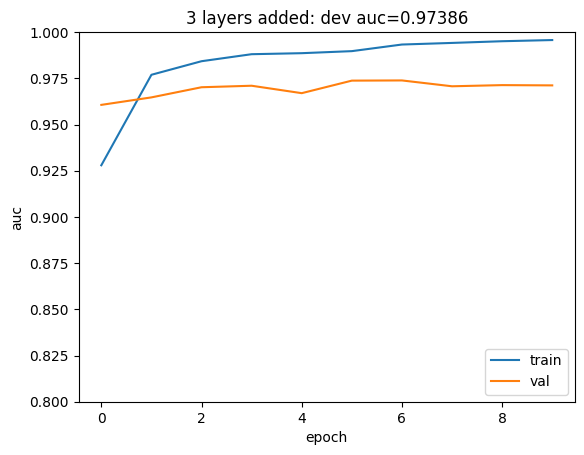

In [51]:
plt.figure()
max_auc=round(np.max(history['val_auc']),5)
plt.title(f'3 layers added: dev auc={max_auc}')
plt.plot(history['auc'])
plt.plot(history['val_auc'])
plt.ylabel('auc')
plt.xlabel('epoch')
plt.ylim([0.8, 1])
plt.legend(['train', 'val'], loc='lower right')
plt.show()

Not we can see more variance creeping in and slightly worse dev set performance as we had expected. 

In [52]:
Train_AUC=history['auc'][-1]
Dev_AUC=history['val_auc'][-1]
print('Train AUC',Train_AUC)
print('Dev AUC',Dev_AUC)
print('difference',Train_AUC-Dev_AUC)

Train AUC 0.9957104921340942
Dev AUC 0.9711776375770569
difference 0.024532854557037354


Let's stick with 3 layers but try fewer hidden units: 10,10,5 

In [53]:
current_model=model_type_3(hidden_units=[10,10,5])
current_model.fit(X_train, y_train,epochs=10, validation_data=(X_dev,y_dev),batch_size=16)
current_model.save('Saved_models/InceptionV3_type_3_smaller',save_format='h5')
np.save('Saved_history/InceptionV3_type_3_smaller_history',current_model.history.history)
tf.keras.backend.clear_session()

Epoch 1/10
113/113 [==============================] - 14s 89ms/step - loss: 0.3324 - auc: 0.9313 - val_loss: 0.3013 - val_auc: 0.9579
Epoch 2/10
113/113 [==============================] - 8s 73ms/step - loss: 0.1966 - auc: 0.9763 - val_loss: 0.2574 - val_auc: 0.9642
Epoch 3/10
113/113 [==============================] - 8s 73ms/step - loss: 0.1577 - auc: 0.9843 - val_loss: 0.2206 - val_auc: 0.9715
Epoch 4/10
113/113 [==============================] - 8s 73ms/step - loss: 0.1468 - auc: 0.9861 - val_loss: 0.3066 - val_auc: 0.9714
Epoch 5/10
113/113 [==============================] - 8s 73ms/step - loss: 0.1424 - auc: 0.9868 - val_loss: 0.2327 - val_auc: 0.9721
Epoch 6/10
113/113 [==============================] - 8s 73ms/step - loss: 0.1097 - auc: 0.9921 - val_loss: 0.2296 - val_auc: 0.9706
Epoch 7/10
113/113 [==============================] - 8s 73ms/step - loss: 0.1091 - auc: 0.9921 - val_loss: 0.2340 - val_auc: 0.9727
Epoch 8/10
113/113 [==============================] - 8s 73ms/step -

In [54]:
history=np.load('Saved_history/InceptionV3_type_3_smaller_history.npy',allow_pickle=True).item()

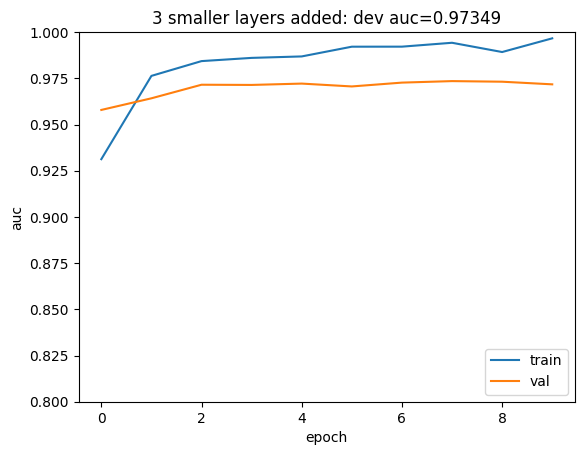

In [55]:
plt.figure()
max_auc=round(np.max(history['val_auc']),5)
plt.title(f'3 smaller layers added: dev auc={max_auc}')
plt.plot(history['auc'])
plt.plot(history['val_auc'])
plt.ylabel('auc')
plt.xlabel('epoch')
plt.ylim([0.8, 1])
plt.legend(['train', 'val'], loc='lower right')
plt.show()

Quite a similar result to the model with more hidden units. What I find most interesting here is how little some of these design choices are actually impacting model performance, I'm getting the impression that starting simple with a model like this and keeping the tuning reasonably brief (unless you start to see large improvements) is probably the way to go. 

## Weight initialisation

In this final section I want to play around with setting the base models weights as trainable part way through training to see how this might effect the model.

In [58]:
'''weights_model=model_type_1('InceptionV3')
weights_model.fit(X_train, y_train,epochs=10, validation_data=(X_dev,y_dev),batch_size=16)

#set a lower learning rate for this stage of training 
weights_model.trainable=True
weights_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])

weights_model.fit(X_train, y_train,epochs=10, validation_data=(X_dev,y_dev),batch_size=16)

np.save('Saved_history/InceptionV3_type_1_trainable',weights_model.history.history)
tf.keras.backend.clear_session()'''

In [61]:
history=np.load('Saved_history/InceptionV3_type_1_trainable.npy',allow_pickle=True).item()

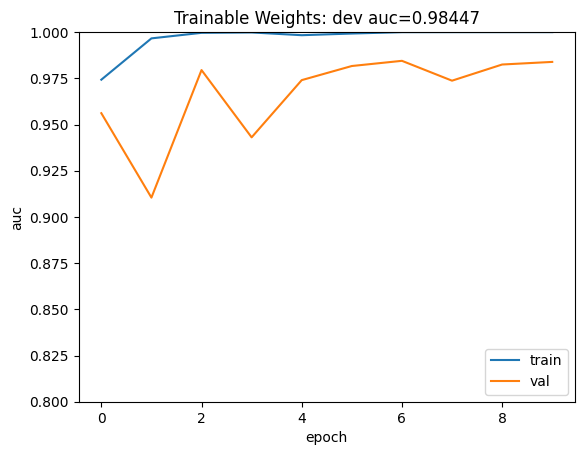

In [63]:
plt.figure()
max_auc=round(np.max(history['val_auc_2']),5)
plt.title(f'Trainable Weights: dev auc={max_auc}')
plt.plot(history['auc_2'])
plt.plot(history['val_auc_2'])
plt.ylabel('auc')
plt.xlabel('epoch')
plt.ylim([0.8, 1])
plt.legend(['train', 'val'], loc='lower right')
plt.show()

Even with a lower learning rate, setting the base models weights to trainable resulted in less steady improvement on the dev set but ultimately, an improved performance. It would be really interesting to experiment with different numbers of epoch and learning rates for each stage. 